# MNIST 데이터 세트 & 데이터 로더 구성


In [42]:
from torchvision import datasets # 예제 데이터 세트
from torchvision.transforms import ToTensor # 이미지 증강(Augmentation). ToTensor -> Torch Tensor로 만들어주는 작업.
from torch.utils.data import DataLoader # 모델에 데이터를 공급하는 역할

In [43]:
train_data = datasets.MNIST(
    root = 'data', # 데이터를 저장할 root 디렉토리
    train = True, # 훈련용 데이터 설정
    download = True, # 다운로드
    transform = ToTensor() # transform: 이미지 증강 기법 지정. 여기서는 단순히 TorchTensor로 변환
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download =True,
    transform = ToTensor()
)

# 시각화

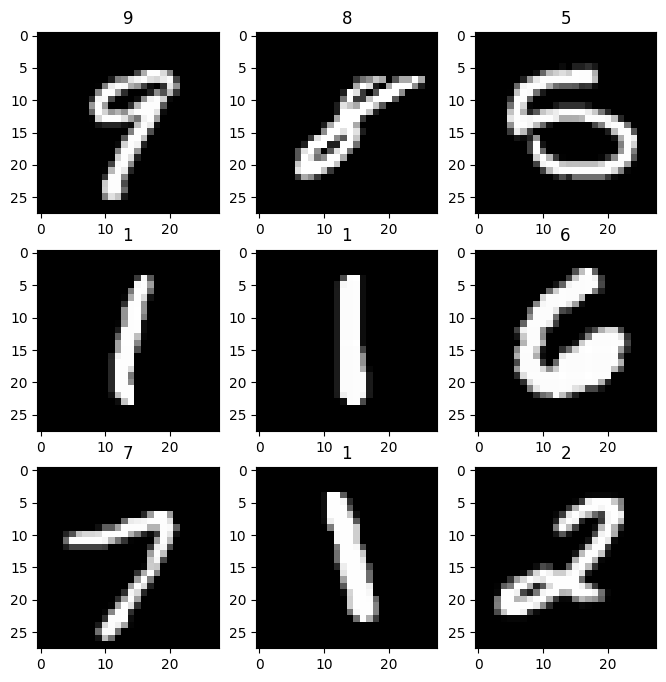

In [44]:
import torch
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1, )).item()
  feature, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.imshow(feature.squeeze(), cmap='gray')

plt.show()

# PyTorch Modeling
- 파이토치는 대부분 서브 클래싱을 활용한 모델링을 수행합니다. 즉, 상속을 활용한다는 말
  - `torch.nn.Module` 클래스를 상속받아 만든다.
- 필수적으로 오버라이딩 할 메소드는 `__init__`, 순전파를 담당하는 `forward`

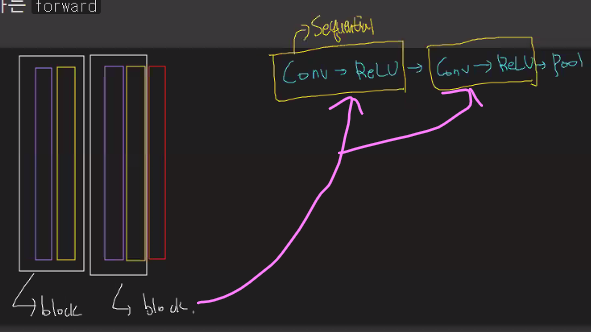

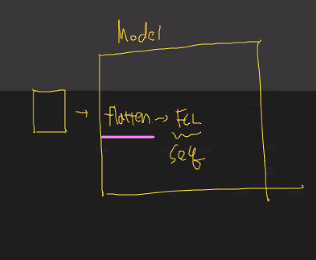

In [45]:
from torch import nn # 딥러닝에 필요한 레이어 패키지

class NeuralNetwork(nn.Module):

  # 사용할 레이어 또는 블록을 정의하는 공간
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.flatten = nn.Flatten()

    # 여러 레이어가 하나의 단위로 묶이는 블록을 만들기 위해서 sequential 사용
    self.linear_relu_stack = nn.Sequential(
        # nn.Linear: Fully Connected 구조. = Keras의 Dense와 같음
        nn.Linear(in_features=28*28, out_features = 128),
        nn.ReLU(),
        nn.Dropout(0.2), # 과대적합 방지/ 훈련 시마다 랜덤하게 가중치 중 20%는 
                        ##  0으로 설정해 사용하지 않음->과대적합 해소
        nn.Linear(128,10) # PyTorch는 출력층에 softmax를 지정하지 않음.
    )

  # 순전파 구현 (입력값 x 입력)
  def forward(self, x):
    x = self.flatten(x)
    y = self.linear_relue_stack(x)

    return y
    

# 모델 생성
파이토치를 활용해 모델 객체를 만들고 나서 어떤 장치 환경에서 훈련이나 추론을 할지 결정해줘야 함

In [46]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device  # 'cuda'라고 결과 나오면 정상적으로 GPU 사용가능한 상황

'cuda'

`cuda` 가 출력되면 GPU 사용이 가능한 상태

In [47]:
model = NeuralNetwork().to(device) # CPU에서 만들어진 모델을 GPU로 옮긴다.
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [48]:
# 또는 cuda() 메소드를 활용할 수도 있다.
model2 = NeuralNetwork().cuda()
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# CNN 모델 구성

## Output Feature Map Size
- $i$ : 입력 feature의 개수
- $o$ : 출력 feature의 수
- $k$ : kernel size
- $p$ : padding size
- $s$ : stride size

$$
o = \bigg(\frac{i+2p-k}{s}\bigg)+1
$$

실수 형태로 크기가 나오면 반드시 정수형태로 바꿔줍니다.

### 예시
- $i$ : 입력 feature의 개수 → 7
- $o$ : 출력 feature의 수 
- $k$ : kernel size → 3
- $p$ : padding size → 0
- $s$ : stride size → 1

$$
o=\bigg(\frac{7+2\times 0-3}{1}\bigg)+1=5
$$

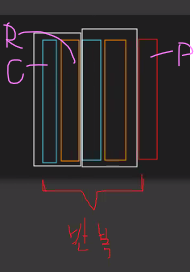

- Conv, ReLU => block
- Pooling => 블록에 포함 x

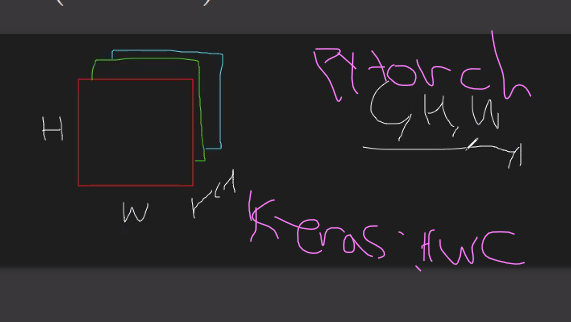

In [49]:
class CustomConvNet(nn.Module):

  def __init__(self):
    super(CustomConvNet, self).__init__()

    # 첫번째 블록 (Conv, ReLU)
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels = 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    ) # 28 x 28

    # pooling
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 입력특성맵의 가로세로크기가 절반이 됨 -> 14 X 14


    # 두두번째 블록 (Conv, ReLU)
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels = 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels = 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    ) # 28 x 28

    # pooling
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
    # 입력특성맵의 가로세로크기가 절반이 됨 -> 7 X 7


    # FCL 구현
    self.classifier = nn.Sequential(
        nn.Linear(32*7*7, 512), nn.ReLU(),
        nn.Linear(512, 256), nn.ReLU(),
        nn.Linear(256,10)
    )

    def forward(self, x):

      # Feature Extraction
      x = self.conv_block1(x)
      x = self.maxpool1(x)

      x = self.conv_block2(x)
      x = self.maxpool2(x)

      # FCL
      x = nn.Flatten()(x)
      y = self.classifier(x)

      return y


In [50]:
cnn_model = CustomConvNet().to(device)
print(cnn_model)

CustomConvNet(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


# 데이터 로더 생성

In [51]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
# train_data = Batch(모집단)에서 64개 뽑아서 미니배치 만들되, 섞어서 만들겠다.

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
# shuffle 할 필요 없음-> 성능만 볼 것이기 때문에
# 훈련 때에는 epoch마다 데이터 다르게 들어오면 훈련을 어렵게 할 수 있음

# 하이퍼 파라미터 선정
- EPOCH 등

In [52]:
EPOCH =10
LEARNING_RATE = 1e-3

In [53]:
# Loss Function & Optimizer
loss_fn = nn.CrossEntropyLoss() 
# sparse_categorical_crossentropy + categorical_cross_entropy, softmax 포함하고 있음

optimizer = torch.optim.Adam(cnn_model.parameters(),lr = LEARNING_RATE) 
# 모델에서 최적화할 파라미터를 넣어준다.

# model.parameters() -> 가중치, 편향, CNN 입장에서는 필터. 최적화에 의해 갱신해야할 대상


# 훈련, 테스트 루틴 정의

In [54]:
def train_loop(dataloader, model, loss_fn, optimizer):
  
  size = len(dataloader.dataset)

  # 모델을 훈련 모드로 설정
  model.train() # 훈련모드로 설정해야지만 가중치, 편향 등을 갱신 가능.

  for batch, (X, y) in enumerate(dataloader):
    # 현재 데이터(X, y)는 CPU에 존재하는 상태. 모델은 gpu에 있음
    X, y= X.to(device), y.to(device)

    # 예측 및 손실함수 확인
    pred = model(X) # pred : softmax 의 결과
    loss = loss_fn(pred,y) # Loss가 등장

    # 미분값 구하기: 역전파 수행해서 구하기
    optimizer.zero_grad() # 기존에 남아있던 기울기를 제거. 이전 배치의 기울기를 반영하지 않기 위함, 초기화.
    loss.backward() # 역전파
    optimizer.step() # 갱신(Adam이라는 경사 하강법을 수행)

   # 배치가 100번 돌 때마다 화면에 출력
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Train Loss : {loss:>7f} [ {current:>5d} / {size:>5d} ]")

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.datset)
  test_loss, correct = 0,0

  # 테스트 할 때는 평가모드(추론모드)
  model.eval()

  # 추론 과정에서는 기울기(gradient)를 구하지 않는다.
  # 훈련은 기울기 구하고 갱신하는게 목적이고, 추론은 순전파만 진행되면 됨.
  with torch.no_grad():
    for X, y in dataloader:
      # 추론 모드에서도 GPU는 활용해야 하기 때문에 데이터를 gpu환경으로 이동동
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item() # item(): 텐서 내에 있는 스칼라 가져오기
      correct += (pred.argmax(1)==y).type(torch.float).sum().item() # 1= axis

  num_batches = len(dataloader)

  # 배치 별 loss 값의 평균 구하기
  test_loss /= num_batches

  # 전체 데이터의 정확도 구하기
  correct /= size

  print(f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")

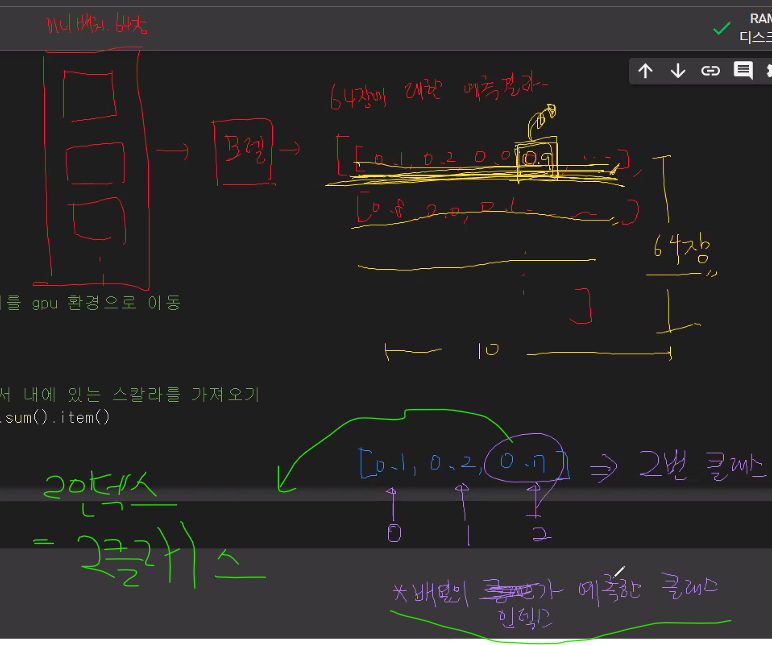

In [55]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loop(test_dataloader, cnn_model, loss_fn)

print("Done!")

Epoch 1
........................


NotImplementedError: ignored